# Autoencoder example

An autoencoder is a type of neural network structure that aims to learn efficiently compressed representations of input dataset. It achieves this by having a network architecture that tapers to some smaller latent space representation, before expanding back to the input size. An autoencoder can generally be thought of as consisting of two networks: the encoder and decoder networks respectively. The encoder is responsible for learning the compressed representation of the input data while the decoder is responsible for reconstructing the input from the latent variable representation.

Autoencoders are useful for a number of tasks such as denoising, feature extraction, data compression and anomaly detection. In this example, we will construct an autoencoder to perform denoising on a sliding window of temporal data.

In [1]:
# Uncomment this to automatically install the moku library in Google Colab or Jupyter Notebook
#%pip install -q moku[neuralnetwork]

# import the relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're running in a Notebook like Google Colab, uncomment the first line in this cell and run it again")
    print("Otherwise install the moku library with neural network extensions using `pip install moku[neuralnetwork]`")
    raise

# set the seed for repeatability
np.random.seed(0)

# Data Generation

To create an effective autoencoder we need to train the model to compress the type of signals that we might expect to see on the Moku. In this example we are simply going to simulate a ringdown signal and apply some noise to it. We will construct a dataset from these noisy signals and allow the autoencoder to “figure out” what the best encoding should be. Since autoencoders are unsupervised learners we don’t need to tell it what the denoised signal should be.

We will start generating our training set by defining the timebase over which we expect to see the signal. We specify a width of 100 to match the maximum width of the Moku neural network input. Note that we define it in terms of 2π so that the frequency of our ringdown is conveniently defined.

In [2]:
# time base, set to width of the network input
T = np.linspace(0, np.pi*2, 100)

We define a ringdown function which will give us the signal we expect to see, this is simply a sinusoidal function with an exponentially decaying envelope. The `ring_down()` function will return two arrays for a given decay, frequency and noise. The first array is the signal without noise while the second has the noise added. In general, we may not have access to the signal without noise, however, in this case we will simply use it for illustrative purposes.

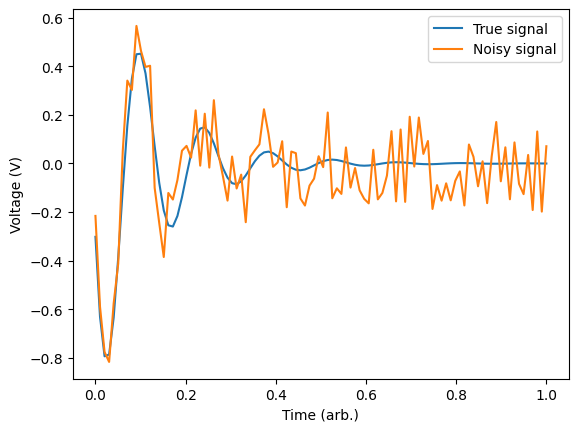

In [3]:
# ringdown function that we expect to acquire
def ring_down(T, decay, frequency, noise):
    """
    :param T: Input array of times
    :param decay: the decay constant of the exponential
    :param frequency: the frequency of the ringdown oscillations
    :param noise: size of the noise applied to the signal
    :return: Two arrays for the signal without and with noise
    """
    # pick a phase randomly
    phase = np.random.uniform(0, np.pi*2, 1)[0]

    # get the signal with and without noise
    no_noise = np.exp(-T/decay)*np.sin(frequency*T + phase)
    with_noise = no_noise + np.random.uniform(-noise, noise, len(T))

    return no_noise, with_noise

# generate an example plot
rd_nn, rd_wn = ring_down(T, 0.8, 7, 0.2)
plt.plot(T/(np.pi*2), rd_nn)
plt.plot(T/(np.pi*2), rd_wn)
plt.legend(['True signal', 'Noisy signal'])
plt.xlabel('Time (arb.)')
plt.ylabel('Voltage (V)')
plt.show()

Here we can see that we end up with a noisy version of the ring down signal for a specific frequency and decay. We will now generate a set of training data that we will use to train the model. To do this, we will generate a large number of noisy signals with random frequencies in the range `[3, 15]` and random decays between `[0.8, 1.5]`. We will fix the noise as having amplitude `0.2`. We will save these into an array and also keep track of the noiseless traces for comparison later.

In [4]:
# define the lengtht of our training data
data_len = 1000

# pre-define the arrays
training_data = np.zeros((data_len, T.size))
noiseless = np.zeros((data_len, T.size))

# generate a all of the random waveforms for training and store them
for idx in tqdm(range(data_len)):
    decay = np.random.uniform(0.8, 1.5, 1)[0]
    frequency = np.random.uniform(3, 15, 1)[0]

    # get the ringdown arrays
    Y_no_noise, Y_train = ring_down(T, decay, frequency, 0.2)

    training_data[idx, :] = Y_train
    noiseless[idx, :] = Y_no_noise

100%|██████████| 1000/1000 [00:00<00:00, 76675.51it/s]


# Model definition and training

Now that we have created a training set we will create a model that can be transferred to the Moku after training. Using the provided package we will create an instance of the quantised model. This custom model class will take care of all our quantisation and data scaling.

In [5]:
# create the model object representing the quantized neural network in the Moku
quant_mod = LinnModel()

Since we have constructed our training data, we can tell the model what to use for training. This will automatically set up the scaling such that the inputs and outputs are mapped to the domain `[-1, 1]` which will facilitate later quantisation.

In [6]:
quant_mod.set_training_data(training_inputs=training_data, training_outputs=training_data)

We now need to define our model structure. To define a structure we will pass a list which contains the model definition. The definition is expected to be a list of tuples of either `(layer_size)` or `(layer_size, layer_activation)`. In our case we are going to define a 3 layer autoencoder which constricts to a latent space size of `8` with the intermediate layers each having a `tanh` activation function. The `show_summary` flag will output the model structure constructed in Tensorflow. There will be a number of intermediate layers for clipping the outputs to conform with the Moku FPGA requirements, but these can largely be ignored. 

In [7]:
# model definition for an autoencoder
model_definition = [(32, 'tanh'), (8, 'tanh'), (32, 'tanh'), (100, 'linear')]

# build the model
quant_mod.construct_model(model_definition, show_summary=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer               │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_1             │ (None, 8)              │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_2             │ (None, 32)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_3             │ (None, 100)            │             0 │
│ (OutputClipLayer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,084 (27.67 KB)

 Trainable params: 7,084 (27.67 KB)

 Non-trainable params: 0 (0.00 B)

We are now ready to train the model! This can be achieved by simply calling the `fit_model()` function and defining a number of training epochs. For this example we will also specify two additional parameters. The first is `validation_split` which corresponds to the percentage of training data that will be removed from the training process and instead used to validate the performance of the model. Using the validation data we will also define an early stopping configuration with the keyword `es_config`. In this configuration we will define 2 parameters: patience which defines how many epochs we go without seeing model improvement, and, restore which reverts the model to its most performant point.

In [8]:
# define the configuration for the early stopping
early_stopping_config = {'patience': 50, 'restore':True}

# set the training data
history = quant_mod.fit_model(epochs=1000, es_config=early_stopping_config, validation_split=0.1)

Value for monitor missing. Using default:val_loss.


Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2618 - val_loss: 0.2320
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2289 - val_loss: 0.2172
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2142 - val_loss: 0.2074
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 0.2049 - val_loss: 0.1996
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 0.1977 - val_loss: 0.1934
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 0.1913 - val_loss: 0.1885
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.1859 - val_loss: 0.1853
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.1816 - val_loss: 0.1827
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.1795 - val_loss: 0.1812
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.1782 - val_loss: 0.1799
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.1761 - val_loss: 0.1790
Epoch 12/1000
29/29 ━━━━━━━━━━━━━━━━

The history object that is returned contains a history of the training and validation losses. We can plot this to view how the model trained over the epochs. In the case the validation loss starts to increase our early stopping will kick in and halt the model training.

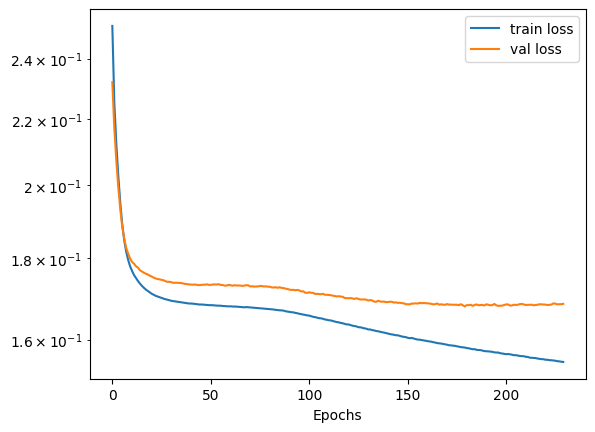

In [9]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.show()

# Assess the model performance

Now the model has finished training we can view its performance by viewing some specific examples. We will pick an example from the validation set (the last 10%) to ensure our model is behaving correctly. Calling the predict method will effectively give use the denoised signal via the autoencoder.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


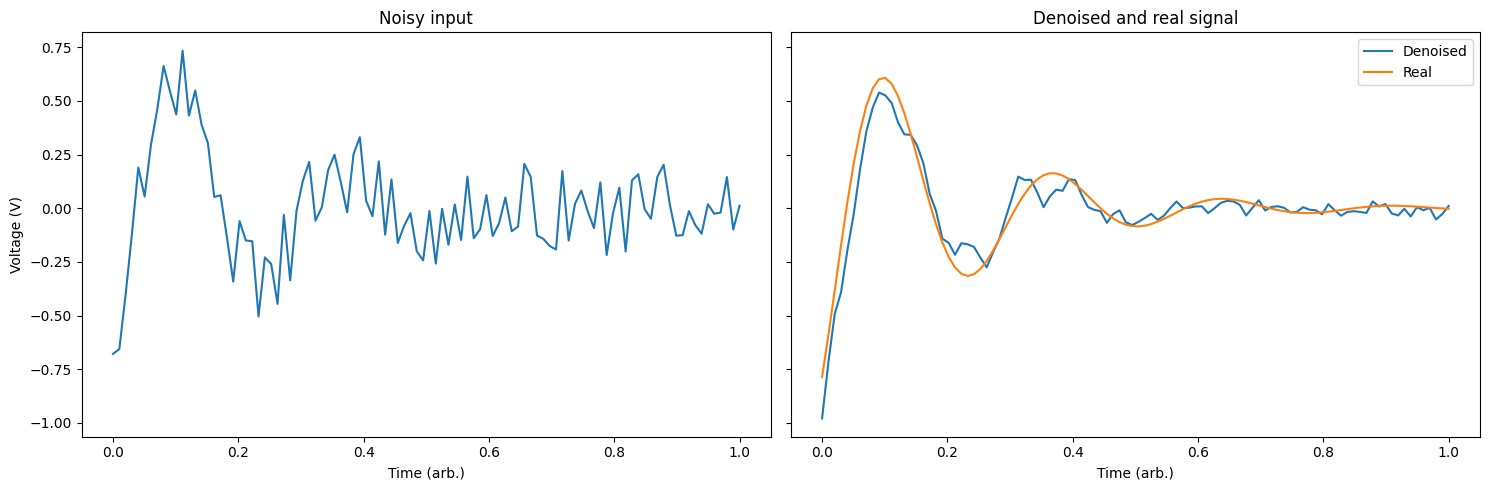

In [10]:
# get all the denoised signals
preds = quant_mod.predict(training_data)

# specify some signal to look at
N = 990

fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True)
# the noisy signal
ax[0].plot(T/(np.pi*2), training_data[N])
ax[0].set_title('Noisy input')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_xlabel('Time (arb.)')

# the recovered signal
ax[1].plot(T/(np.pi*2), preds[N])
ax[1].set_title('Denoised and real signal')
ax[1].plot(T/(np.pi*2), noiseless[N])
ax[1].set_xlabel('Time (arb.)')
ax[1].legend(['Denoised', 'Real'])
plt.tight_layout()
plt.show()

We can also compare this to a traditional Gaussian smoothing filter to compare the performance of the autoencoder.

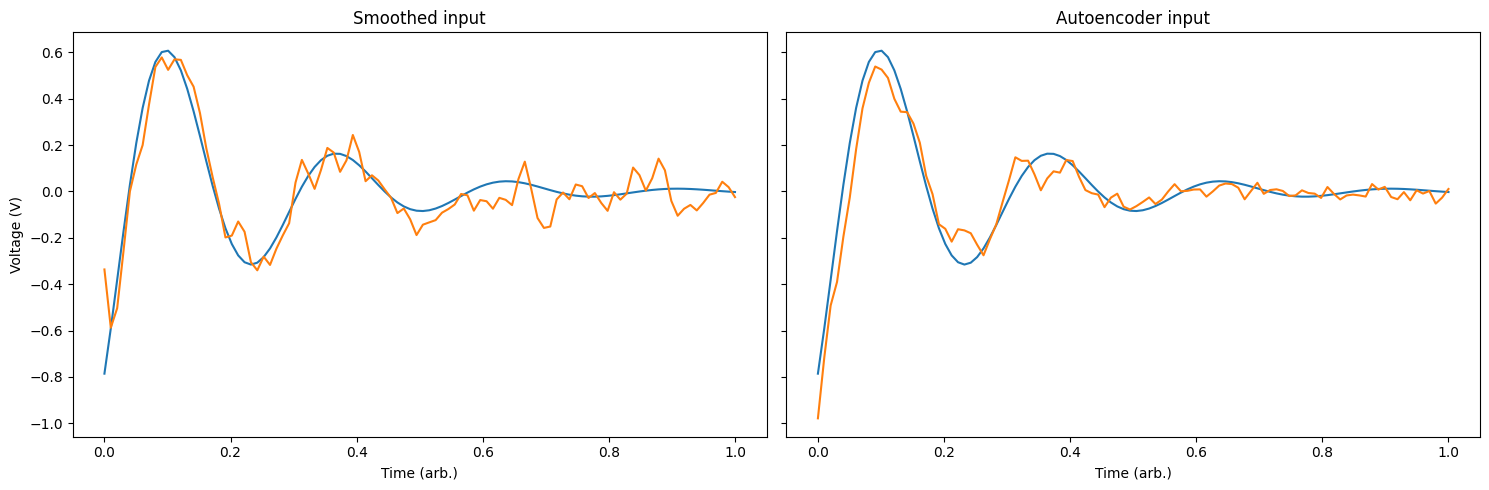

In [11]:
# smooth the input using a Gaussian filter
filter = np.exp(-np.linspace(-1, 1, T.size)**2 / 5e-4)
filter /= np.sum(filter)
conv = np.convolve(filter, training_data[N], mode='same')

fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True)
# plot the smoothed solution
ax[0].plot(T/(np.pi*2), noiseless[N])
ax[0].plot(T/(np.pi*2), conv)
ax[0].set_title('Smoothed input')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_xlabel('Time (arb.)')

# plot the autoencoder solution
ax[1].plot(T/(np.pi*2), noiseless[N])
ax[1].plot(T/(np.pi*2), preds[N])
ax[1].set_title('Autoencoder input')
ax[1].set_xlabel('Time (arb.)')

plt.tight_layout()
plt.show()